# PCA & FA

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from factor_analyzer import FactorAnalyzer


In [2]:
# https://public.opendatasoft.com/api/records/1.0/search/?dataset=airbnb-listings&q=where+country_code+%3D+'US'+and+city+%3D+%22New+York%22&rows=10
r = requests.get("https://public.opendatasoft.com/api/records/1.0/search/?dataset=airbnb-listings&q=where+country_code+%3D+'US'&rows=10000")#+and+city+%3D+%22New+York%22
records = r.json()['records']

In [3]:
df_records = []
for r in records:
  df_records.append(r['fields'])

In [4]:
df = pd.DataFrame(df_records)


df = df.sort_index(axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   access                          7624 non-null   object 
 1   accommodates                    9995 non-null   float64
 2   amenities                       9955 non-null   object 
 3   availability_30                 10000 non-null  int64  
 4   availability_365                10000 non-null  int64  
 5   availability_60                 10000 non-null  int64  
 6   availability_90                 10000 non-null  int64  
 7   bathrooms                       9978 non-null   float64
 8   bed_type                        10000 non-null  object 
 9   bedrooms                        9998 non-null   float64
 10  beds                            9994 non-null   float64
 11  calculated_host_listings_count  10000 non-null  int64  
 12  calendar_last_scraped           1

In [6]:
df = df.drop(['access', 'availability_30', 'availability_60', 'availability_90', 'calculated_host_listings_count', 'calendar_last_scraped', 'calendar_updated', 'city', 'country', 'country_code', 
         'description', 'experiences_offered', 'first_review', 'geolocation', 'guests_included', 'host_about', 'host_id', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood',
         'host_picture_url', 'host_since', 'host_thumbnail_url', 'host_url', 'house_rules', 'id', 'interaction', 'jurisdiction_names', 'last_review', 'last_scraped', 'latitude', 'license', 'listing_url', 'longitude', 'market',
         'medium_url', 'monthly_price', 'name', 'neighborhood_overview', 'neighbourhood', 'neighbourhood_cleansed', 'notes', 'picture_url', 'property_type', 'scrape_id', 'smart_location', 'space', 'state', 'street',
         'summary', 'square_feet', 'thumbnail_url', 'transit', 'weekly_price', 'xl_picture_url', 'zipcode'], axis=1)

In [7]:
def bed_type(row):
  bed = row['bed_type']
  if(bed == 'Real Bed'):
    return 1
  elif(bed=='Futon'):
    return 2
  elif(bed=='Airbed'):
    return 3
  elif(bed=='Couch'):
    return 4
  elif(bed=='Pull-out Sofa'):
    return 5
  else:
    return 0
  
def cancellation(row):
  cancel = row['cancellation_policy']
  if(cancel == 'flexible'):
    return 1
  elif(cancel == 'moderate'):
    return 2
  elif(cancel == 'strict'):
    return 3
  elif(cancel.index('super_strict')!=-1) :
    return 4
  else:
    return 0

def response_time(row):
  r_time = row['host_response_time']
  if(r_time == 'within an hour'):
    return 0
  elif(r_time == 'within a few hours'):
    return 1
  elif(r_time == 'within a day'):
    return 2
  elif(r_time == 'a few days or more'):
    return 3
  else:
    return 4

def room_type(row):
  r_type = row['room_type']
  if(r_type == 'Shared room'):
    return 0
  elif(r_type == 'Private room'):
    return 1
  elif(r_type == 'Entire home/apt'):
    return 2
  else:
    return 3
  

In [8]:
# 1) amenities 수에 따라 변환.
# 2) features들을 나누어 표현 ('Host Has Profile Pic', 'Host Identity Verified', 'Host Is Superhost', 'Instant Bookable', 'Is Location Exact', 'Require Guest Phone Verification', 'Require Guest Profile Picture')
for idx, row in df.iterrows():
    # print(row['amenities'].notnull())
    # print(row['amenities'])
    try:
      
      df.loc[idx, 'amenities'] = len(row['amenities'].split(',')) if row['amenities']!=float('nan') else 0
    
      df.loc[idx, 'host_has_profile_pic'] = 1 if row['features'].find('Host Has Profile Pic') != -1 else 0
      df.loc[idx, 'host_identity_verified'] = 1 if row['features'].find('Host Identity Verified') != -1 else 0
      df.loc[idx, 'host_is_superhost'] = 1 if row['features'].find('Host Is Superhost') != -1 else 0
      df.loc[idx, 'instant_bookable'] = 1 if row['features'].find('Instant Bookable') != -1 else 0
      df.loc[idx, 'is_location_exact'] = 1 if row['features'].find('Is Location Exact') != -1 else 0
      df.loc[idx, 'instant_bookable'] = 1 if row['features'].find('Instant Bookable') != -1 else 0
      df.loc[idx, 'require_guest_phone_verification'] = 1 if row['features'].find('Require Guest Phone Verification') != -1 else 0
      df.loc[idx, 'require_guest_profile_picture'] = 1 if row['features'].find('Require Guest Profile Picture') != -1 else 0

      df.loc[idx, 'host_verifications_num'] = len(row['host_verifications'].split(',')) if row['host_verifications']!='None' else 0

    except:
      df.loc[idx, 'host_verifications_num'] =  0

      # print(row['amenities'])
      # print(type(row['amenities']))
      # print(row['host_verifications'])
    


# bed_type - categorize (Real Bed - 1, Futon - 2, Airbed - 3, Couch - 4, Pull-out Sofa - 5 --> 밑에 분포에 보면 그냥 삭제해도 될 거 같음.)
df['bed_type'] = df.apply(bed_type, axis=1)

# cancellation_policy - catogorize( flexible - 1, moderate - 2, strict - 3, super_strict - 4 )
df['cancellation_policy'] = df.apply(cancellation, axis=1)

# host_response_time - categorize (within an hour - 0, within a few hours-1, within a day - 2, a few days or more - 3)
df['host_response_time'] = df.apply(response_time, axis=1)

# room_type - categorize (within an hour - 0, within a few hours-1, within a day - 2, a few days or more - 3)
df['room_type'] = df.apply(room_type, axis=1)



df = df.sort_index(axis=1)
df = df.fillna(0) #Null 값 존재 - cleaning_fee, has_availablility, host_acceptance_rate, host_response_rate
df = df.select_dtypes(exclude=['object'])
df


,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,extra_people,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit
0,1.0,15,179,1.0,1,1.0,1.0,1,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0.0
1,1.0,13,88,1.0,4,1.0,1.0,1,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0
2,1.0,18,316,1.0,1,1.0,1.0,1,10.0,0,...,10.0,10.0,9.0,10.0,9.0,94.0,10.0,5.98,1,100.0
3,2.0,20,365,1.0,1,1.0,1.0,3,0.0,10,...,9.0,9.0,8.0,9.0,7.0,86.0,9.0,0.81,1,0.0
4,5.0,17,353,1.0,1,1.0,5.0,3,120.0,0,...,10.0,9.0,10.0,10.0,10.0,100.0,10.0,1.71,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,14,329,1.5,1,1.0,1.0,3,0.0,0,...,10.0,10.0,10.0,10.0,10.0,100.0,10.0,0.79,1,0.0
9996,10.0,17,344,2.0,1,3.0,5.0,3,300.0,35,...,9.0,10.0,9.0,9.0,10.0,93.0,9.0,0.67,2,0.0
9997,4.0,20,2,1.0,1,1.0,2.0,1,35.0,0,...,10.0,10.0,10.0,10.0,10.0,100.0,10.0,0.17,2,150.0
9998,3.0,18,311,1.0,1,1.0,2.0,2,115.0,15,...,10.0,10.0,10.0,10.0,10.0,100.0,10.0,1.00,2,250.0


In [9]:
# Categorize 1 - Bed_Type
df['bed_type'].value_counts()
# Real Bed - 1, Futon - 2, Airbed - 3, Couch - 4, Pull-out Sofa - 5 --> 그냥 삭제해도 될 거 같음. 

1    9675
2     120
5      97
3      66
4      42
Name: bed_type, dtype: int64

In [10]:
# Categorize 2 - cancellation policy
df['cancellation_policy'].value_counts()
# flexible - 1, moderate - 2, strict - 3, super_strict - 4

3    4524
2    3001
1    2465
4      10
Name: cancellation_policy, dtype: int64

In [11]:
#Categorize 3 - host_response_time
df['host_response_time'].value_counts()
# within an hour - 0, within a few hours-1, within a day - 2, a few days or more - 3

0    4853
1    1968
4    1808
2    1184
3     187
Name: host_response_time, dtype: int64

In [12]:
#Categorize 4 - room_type
df['room_type'].value_counts()
# Shared room - 0, Private room - 1, Entire home/apt - 2, else - 3

2    5748
1    3862
0     390
Name: room_type, dtype: int64

In [13]:
df.describe()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,extra_people,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,3.422900,17.777800,170.478000,1.286500,1.076600,1.346900,1.870400,2.207900,50.237400,14.65750,...,7.977400,8.093300,7.823400,8.108700,7.873900,78.232900,7.835600,1.586701,1.535800,129.81170
std,2.285471,5.609329,137.730776,0.642658,0.474926,0.913807,1.460006,0.812246,54.872772,23.64973,...,3.721918,3.765875,3.684287,3.764798,3.692176,36.427256,3.679637,1.848328,0.571621,181.58726
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,14.000000,29.000000,1.000000,1.000000,1.000000,1.000000,2.000000,10.000000,0.00000,...,9.000000,9.000000,8.000000,9.000000,9.000000,87.000000,9.000000,0.180000,1.000000,0.00000
50%,2.000000,18.000000,152.000000,1.000000,1.000000,1.000000,1.000000,2.000000,35.000000,7.00000,...,10.000000,10.000000,10.000000,10.000000,10.000000,95.000000,9.000000,0.930000,2.000000,0.00000
75%,4.000000,22.000000,319.000000,1.000000,1.000000,2.000000,2.000000,3.000000,75.000000,25.00000,...,10.000000,10.000000,10.000000,10.000000,10.000000,99.000000,10.000000,2.380000,2.000000,200.00000
max,16.000000,58.000000,365.000000,8.000000,5.000000,8.000000,16.000000,4.000000,650.000000,500.00000,...,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,10.000000,12.630000,2.000000,999.00000


In [14]:
# scaling (z-standardization)
data_scale = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index = df.index)
data_scale.head()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,extra_people,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit
0,-1.060185,-0.495235,0.061877,-0.445827,-0.161296,-0.379639,-0.596192,-1.487185,-0.915571,-0.619806,...,-2.143464,-2.149223,-2.123556,-2.153929,-2.132697,-2.147755,-2.129556,-0.858495,-0.937381,-0.714908
1,-1.060185,-0.851802,-0.598865,-0.445827,6.155789,-0.379639,-0.596192,-1.487185,-0.915571,-0.619806,...,-2.143464,-2.149223,-2.123556,-2.153929,-2.132697,-2.147755,-2.129556,-0.858495,-2.686878,-0.714908
2,-1.060185,0.039615,1.056621,-0.445827,-0.161296,-0.379639,-0.596192,-1.487185,-0.733322,-0.619806,...,0.543457,0.506335,0.319372,0.502389,0.305012,0.432860,0.588240,2.377023,-0.937381,-0.164181
3,-0.622616,0.396181,1.412406,-0.445827,-0.161296,-0.379639,-0.596192,0.975246,-0.915571,-0.196947,...,0.274765,0.240779,0.047936,0.236758,-0.236702,0.213233,0.316460,-0.420239,-0.937381,-0.714908
4,0.690089,-0.138669,1.325275,-0.445827,-0.161296,-0.379639,2.143660,0.975246,1.271415,-0.619806,...,0.543457,0.240779,0.590809,0.502389,0.575868,0.597580,0.588240,0.066712,0.812117,-0.714908


In [15]:
# covariance
data_scale.cov()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,extra_people,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit
accommodates,1.000100,0.247965,0.103117,0.566087,-0.082928,0.766690,0.787681,0.198804,0.555817,0.140863,...,0.002253,0.005153,0.011829,0.002852,0.005290,0.006518,0.004855,0.004682,0.450105,0.231136
amenities,0.247965,1.000100,0.056111,0.193668,-0.029127,0.177681,0.217782,0.165962,0.210327,0.115854,...,0.136384,0.129041,0.147746,0.127881,0.131397,0.140635,0.140344,0.205519,0.124168,0.130434
availability_365,0.103117,0.056111,1.000100,0.067084,0.003365,0.067032,0.086401,0.136172,0.132106,0.096269,...,0.133497,0.140234,0.145890,0.138827,0.138169,0.135546,0.134385,0.119464,-0.039575,0.067789
bathrooms,0.566087,0.193668,0.067084,1.000100,-0.051764,0.621671,0.622463,0.128258,0.418139,0.108480,...,-0.035073,-0.036319,-0.031853,-0.038050,-0.039380,-0.032154,-0.031489,-0.057906,0.101538,0.105782
bed_type,-0.082928,-0.029127,0.003365,-0.051764,1.000100,-0.063545,-0.060977,-0.025216,-0.058298,-0.030087,...,0.009863,0.010543,0.010133,0.010782,0.008818,0.009103,0.007208,-0.002164,-0.151580,-0.037173
bedrooms,0.766690,0.177681,0.067032,0.621671,-0.063545,1.000100,0.681730,0.146316,0.530419,0.099381,...,-0.034278,-0.033095,-0.027640,-0.034367,-0.036213,-0.028983,-0.031432,-0.098105,0.294556,0.207740
beds,0.787681,0.217782,0.086401,0.622463,-0.060977,0.681730,1.000100,0.193096,0.449115,0.135338,...,0.007817,0.011041,0.016217,0.009606,0.005781,0.010862,0.011877,0.008255,0.226796,0.164870
cancellation_policy,0.198804,0.165962,0.136172,0.128258,-0.025216,0.146316,0.193096,1.000100,0.304642,0.141095,...,0.186335,0.190211,0.195964,0.188793,0.188542,0.189983,0.184387,0.099759,0.133793,0.232537
cleaning_fee,0.555817,0.210327,0.132106,0.418139,-0.058298,0.530419,0.449115,0.304642,1.000100,0.174637,...,0.024130,0.021067,0.036054,0.020772,0.035839,0.028536,0.020055,-0.089743,0.443732,0.362850
extra_people,0.140863,0.115854,0.096269,0.108480,-0.030087,0.099381,0.135338,0.141095,0.174637,1.000100,...,0.076475,0.076270,0.080767,0.076107,0.077478,0.078173,0.073434,0.002657,0.026140,0.145209


In [16]:
# correlation
data_scale.corr()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,extra_people,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit
accommodates,1.000000,0.247940,0.103107,0.566031,-0.082919,0.766613,0.787602,0.198784,0.555761,0.140849,...,0.002252,0.005153,0.011828,0.002851,0.005289,0.006517,0.004855,0.004682,0.450060,0.231113
amenities,0.247940,1.000000,0.056106,0.193649,-0.029124,0.177663,0.217760,0.165945,0.210306,0.115842,...,0.136370,0.129029,0.147731,0.127868,0.131384,0.140621,0.140330,0.205498,0.124156,0.130421
availability_365,0.103107,0.056106,1.000000,0.067078,0.003365,0.067025,0.086392,0.136159,0.132093,0.096259,...,0.133484,0.140220,0.145876,0.138813,0.138155,0.135533,0.134372,0.119452,-0.039571,0.067783
bathrooms,0.566031,0.193649,0.067078,1.000000,-0.051759,0.621609,0.622401,0.128245,0.418097,0.108469,...,-0.035070,-0.036315,-0.031850,-0.038046,-0.039376,-0.032150,-0.031486,-0.057900,0.101528,0.105772
bed_type,-0.082919,-0.029124,0.003365,-0.051759,1.000000,-0.063539,-0.060971,-0.025213,-0.058293,-0.030084,...,0.009862,0.010542,0.010132,0.010780,0.008817,0.009102,0.007207,-0.002164,-0.151564,-0.037169
bedrooms,0.766613,0.177663,0.067025,0.621609,-0.063539,1.000000,0.681662,0.146302,0.530366,0.099371,...,-0.034275,-0.033091,-0.027637,-0.034363,-0.036209,-0.028981,-0.031429,-0.098095,0.294526,0.207719
beds,0.787602,0.217760,0.086392,0.622401,-0.060971,0.681662,1.000000,0.193077,0.449070,0.135324,...,0.007817,0.011040,0.016215,0.009605,0.005781,0.010861,0.011876,0.008255,0.226774,0.164854
cancellation_policy,0.198784,0.165945,0.136159,0.128245,-0.025213,0.146302,0.193077,1.000000,0.304612,0.141081,...,0.186316,0.190192,0.195945,0.188774,0.188523,0.189964,0.184368,0.099749,0.133779,0.232514
cleaning_fee,0.555761,0.210306,0.132093,0.418097,-0.058293,0.530366,0.449070,0.304612,1.000000,0.174619,...,0.024128,0.021065,0.036050,0.020770,0.035835,0.028533,0.020053,-0.089734,0.443687,0.362814
extra_people,0.140849,0.115842,0.096259,0.108469,-0.030084,0.099371,0.135324,0.141081,0.174619,1.000000,...,0.076467,0.076262,0.080759,0.076099,0.077470,0.078165,0.073426,0.002657,0.026138,0.145195


In [17]:
# PCA 진행
pca = PCA(random_state=20210323)
X_p = pca.fit_transform(data_scale)
# Eigen value
fa= FactorAnalyzer(n_factors=data_scale.shape[1], rotation=None)
fa.fit(data_scale)

ev, v = fa.get_eigenvalues()
ev

array([7.99968558e+00, 4.41482227e+00, 2.21273375e+00, 1.90381886e+00,
       1.64263193e+00, 1.30498089e+00, 1.27339283e+00, 1.11620829e+00,
       1.08189306e+00, 1.01444557e+00, 9.70708024e-01, 9.63310028e-01,
       9.40085190e-01, 9.10306649e-01, 8.31286687e-01, 7.89566830e-01,
       7.60777803e-01, 7.15909475e-01, 6.77146719e-01, 6.54548876e-01,
       5.02757713e-01, 4.56792849e-01, 3.78234697e-01, 3.64512641e-01,
       3.03934030e-01, 2.82743578e-01, 2.03664238e-01, 1.49662222e-01,
       7.52489163e-02, 3.65179890e-02, 2.00506454e-02, 1.60413702e-02,
       1.34135775e-02, 1.06618039e-02, 7.50442180e-03])

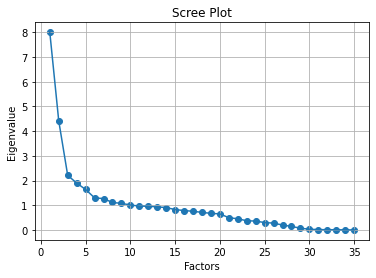

In [18]:
# 시각화 1
plt.scatter(range(1, data_scale.shape[1]+1),ev)
plt.plot(range(1,data_scale.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [19]:
# 분산 설명 비율
each_variance_ratio = pca.explained_variance_ratio_
each_variance_ratio #각 PC별 분산 설명 비율

array([2.28562445e-01, 1.26137779e-01, 6.32209643e-02, 5.43948245e-02,
       4.69323408e-02, 3.72851682e-02, 3.63826523e-02, 3.18916655e-02,
       3.09112303e-02, 2.89841592e-02, 2.77345150e-02, 2.75231437e-02,
       2.68595769e-02, 2.60087614e-02, 2.37510482e-02, 2.25590523e-02,
       2.17365087e-02, 2.04545564e-02, 1.93470491e-02, 1.87013965e-02,
       1.43645061e-02, 1.30512243e-02, 1.08067056e-02, 1.04146469e-02,
       8.68382942e-03, 8.07838793e-03, 5.81897822e-03, 4.27606348e-03,
       2.14996904e-03, 1.04337112e-03, 5.72875582e-04, 4.58324864e-04,
       3.83245071e-04, 3.04622967e-04, 2.14412051e-04])

In [20]:
# 누적 분산 설명 비율
cumsum = np.cumsum(pca.explained_variance_ratio_)

pd.Series(np.cumsum(pca.explained_variance_ratio_)) #고유값을 기준으로 설명 가능한 분산 (누적)

0     0.228562
1     0.354700
2     0.417921
3     0.472316
4     0.519248
5     0.556534
6     0.592916
7     0.624808
8     0.655719
9     0.684703
10    0.712438
11    0.739961
12    0.766820
13    0.792829
14    0.816580
15    0.839139
16    0.860876
17    0.881330
18    0.900677
19    0.919379
20    0.933743
21    0.946795
22    0.957601
23    0.968016
24    0.976700
25    0.984778
26    0.990597
27    0.994873
28    0.997023
29    0.998067
30    0.998639
31    0.999098
32    0.999481
33    0.999786
34    1.000000
dtype: float64

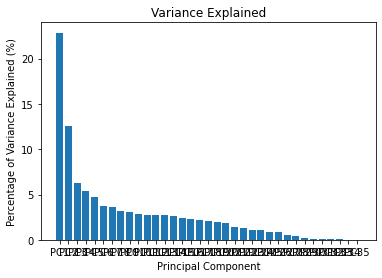

In [21]:
# 시각화 2
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained (%)')
plt.xlabel('Principal Component')
plt.title('Variance Explained')
plt.show()

In [22]:
# PC 선택
# eigenvalue > 1 인 pc 선택 -> 10개
pd.DataFrame(pca.components_[:,:10],
             columns = ['PC1','PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
             index=df.columns)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
accommodates,-0.017798,-0.083116,-0.076067,0.004150,-0.001382,0.004119,-0.018845,-0.094049,-0.023403,-0.039374
amenities,0.418495,0.161251,0.068105,0.330429,-0.058891,0.393388,0.377775,0.155941,0.355733,0.102517
availability_365,-0.039557,0.220645,0.194643,-0.037250,0.005027,-0.087139,-0.014194,0.098686,-0.054955,0.025562
bathrooms,-0.061386,-0.032741,-0.041482,-0.059812,0.013228,-0.026167,-0.079024,0.088577,0.046395,0.084233
bed_type,0.028915,-0.157139,0.219707,0.009400,-0.023942,0.019756,0.028953,0.002201,0.013634,-0.001199
bedrooms,-0.144874,0.001540,0.150520,-0.328345,-0.132325,-0.208518,-0.283144,0.296944,0.226110,0.166338
beds,0.064545,0.102502,-0.337314,-0.106804,-0.166182,-0.015589,-0.029398,-0.155787,-0.027818,-0.122385
cancellation_policy,-0.037522,0.023414,-0.219641,-0.102139,-0.300703,-0.074090,-0.067342,0.136013,0.027278,-0.381762
cleaning_fee,-0.061557,0.171865,-0.108354,0.076612,0.298382,0.013859,0.028215,0.075593,0.028818,0.135234
extra_people,-0.008380,0.196372,-0.194884,0.005033,-0.493848,-0.040793,0.019289,-0.028654,-0.048596,0.438834


<AxesSubplot:>

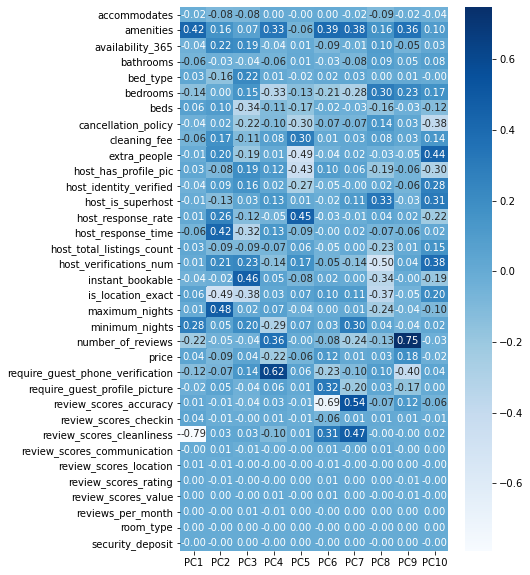

In [23]:
pca_result = pd.DataFrame(pca.components_[:,:10],
             columns = ['PC1','PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
             index=df.columns)
plt.figure(figsize=(6,10))
sns.heatmap(pca_result, cmap="Blues", annot=True, fmt='.2f') #소수 둘째자리까지

In [24]:
X_pp = pd.DataFrame(X_p[:,:10],
                    columns = ['PC1','PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                    index = df.index)
X_pp #PCA 이후 만들어진 data (PC1~ PC10로 총 10개 변수로 축소)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,5.743096,-1.594506,2.324142,-1.129600,1.583528,-0.530030,0.010273,0.728175,1.852792,0.785018
1,6.944213,-2.919726,-0.507073,-0.124658,1.303029,-2.002192,-0.566235,-2.539086,3.477053,-3.088250
2,-2.431439,-2.424405,2.719216,-0.702630,2.291791,-0.366377,3.635257,-1.718565,0.101032,-1.791811
3,-0.399688,-1.338205,0.178712,-0.179410,-0.162590,0.098250,-1.317643,-0.076567,-0.210220,-0.565385
4,-0.963868,1.663460,-0.804193,-1.773193,2.169652,0.001630,-0.811495,1.072727,-1.144468,0.994644
...,...,...,...,...,...,...,...,...,...,...
9995,-1.643218,-1.305507,0.216156,-0.039719,-1.316309,-0.391658,-2.006961,0.015831,-0.621920,-0.559570
9996,-1.780580,5.819451,0.351241,6.196679,1.907053,-1.682326,-1.167558,0.142598,-0.759496,0.054808
9997,-0.207195,-0.634370,-2.620710,0.219764,-0.963270,-0.933400,1.851638,1.171647,0.577982,1.187045
9998,-1.198711,0.222416,-0.821219,-0.866507,1.567092,1.325057,-0.717668,0.479022,0.533217,-0.274670


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

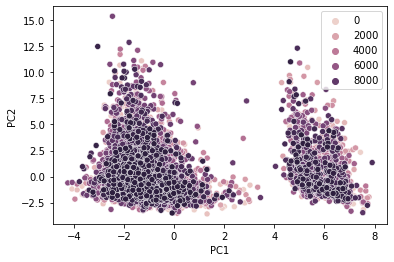

In [25]:
# Principal Component Pattern Plot - PC1 and PC2
sns.scatterplot(data=X_pp, x='PC1',y='PC2',hue=X_pp.index)

<AxesSubplot:xlabel='PC1', ylabel='PC3'>

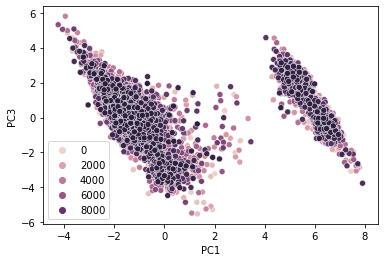

In [26]:
# Principal Component Pattern Plot - PC1 and PC3
sns.scatterplot(data=X_pp, x='PC1',y='PC3',hue=X_pp.index)

<AxesSubplot:xlabel='PC2', ylabel='PC3'>

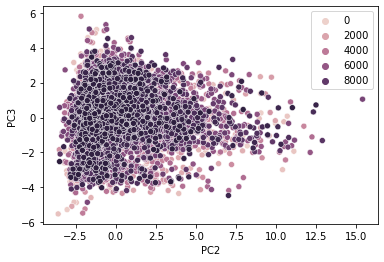

In [27]:
# Principal Component Pattern Plot - PC2 and PC3
sns.scatterplot(data=X_pp, x='PC2',y='PC3',hue=X_pp.index)

In [28]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(data_scale)
chi_square_value, p_value # p-value < 0.05 --> 귀무가설 기각

(328958.6016055157, 0.0)

In [29]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model =calculate_kmo(data_scale)
kmo_model # 0.8 이상이므로 꽤 좋음

C:\Users\leejo\anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8838464339105864

In [30]:
fa = FactorAnalyzer(n_factors=7, rotation = "varimax")
fa.fit(data_scale)

FactorAnalyzer(n_factors=7, rotation='varimax', rotation_kwargs={})

In [31]:
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6','Factor7'],
                                 index=data_scale.columns)
fa_result_loading

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
accommodates,-0.004046,0.794439,0.042367,0.424134,-0.038730,0.082623,0.019243
amenities,0.076115,0.190094,0.209769,0.181183,-0.003306,0.182077,0.209679
availability_365,0.104173,0.062653,0.308213,0.070366,0.056262,0.086276,-0.046078
bathrooms,-0.028962,0.717376,0.052483,0.107271,-0.020621,-0.017822,0.021632
bed_type,0.013555,-0.039735,0.002186,-0.122298,0.009017,-0.024157,0.014350
bedrooms,-0.022865,0.785262,0.016351,0.307208,-0.011377,-0.044320,0.007686
beds,0.005386,0.829923,0.073969,0.183843,-0.027876,0.075305,0.023628
cancellation_policy,0.151739,0.107808,0.209244,0.299870,0.080628,0.030701,0.101224
cleaning_fee,0.016753,0.410320,0.130617,0.641029,0.006999,-0.116073,0.032110
extra_people,0.065063,0.103305,0.080009,0.148118,0.055587,-0.017747,0.057388


<AxesSubplot:>

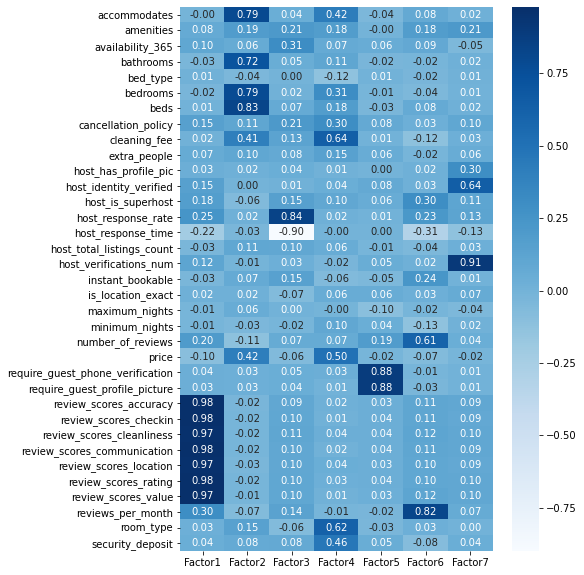

In [32]:
# 시각화
plt.figure(figsize=(7,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')

In [33]:
fa.get_factor_variance()
fa_result_fromLoading = pd.DataFrame(fa.get_factor_variance(), columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5','Factor6','Factor7'])
fa_result_fromLoading.index = ['SS Loadings', 'Proportion Var', 'Cumulative Var']
fa_result_fromLoading

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
SS Loadings,7.018933,2.934736,1.904925,1.784794,1.659565,1.535535,1.511099
Proportion Var,0.200541,0.083850,0.054426,0.050994,0.047416,0.043872,0.043174
Cumulative Var,0.200541,0.284391,0.338817,0.389811,0.437227,0.481100,0.524274


In [34]:
X_f = fa.fit_transform(data_scale)
X_ff = pd.DataFrame(X_f[:,:7], 
                    columns = ['quality of review','quality of room','host response','price','guest information','quantity of review','host verification'], 
                    index = data_scale.index)
X_ff

,quality of review,quality of room,host response,price,guest information,quantity of review,host verification
0,-2.167701,-0.522568,1.558249,-1.036316,-0.178431,-0.171977,-1.582637
1,-1.813071,-0.183037,-1.094238,-1.530528,0.035708,-0.158259,-2.202042
2,0.279359,-0.838991,-0.637446,-0.409363,0.208507,3.090534,-0.387363
3,0.341818,-0.321745,-0.339950,-0.789045,-0.104624,-0.449332,-0.087331
4,0.648446,0.744647,0.161786,0.502709,-0.382646,-0.037988,-1.319781
...,...,...,...,...,...,...,...
9995,0.432281,-0.224829,0.796933,-1.065618,-0.278275,-0.801445,1.751454
9996,0.193944,2.209577,0.257831,1.999911,4.622295,-0.733003,0.747097
9997,0.861627,0.038438,-2.152369,0.169278,-0.207294,-0.586475,-0.162393
9998,0.626892,-0.364366,1.123758,0.609138,-0.338862,-0.629717,-1.189923


<AxesSubplot:xlabel='quality of review', ylabel='quality of room'>

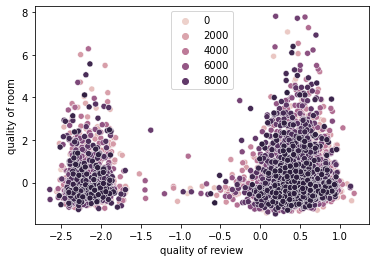

In [35]:
sns.scatterplot(data=X_ff, x='quality of review',y='quality of room',hue=X_ff.index)

<AxesSubplot:xlabel='quality of review', ylabel='quantity of review'>

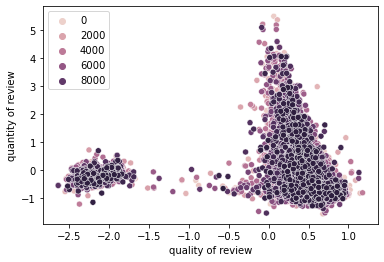

In [36]:
sns.scatterplot(data=X_ff, x='quality of review',y='quantity of review',hue=X_ff.index)

<AxesSubplot:>

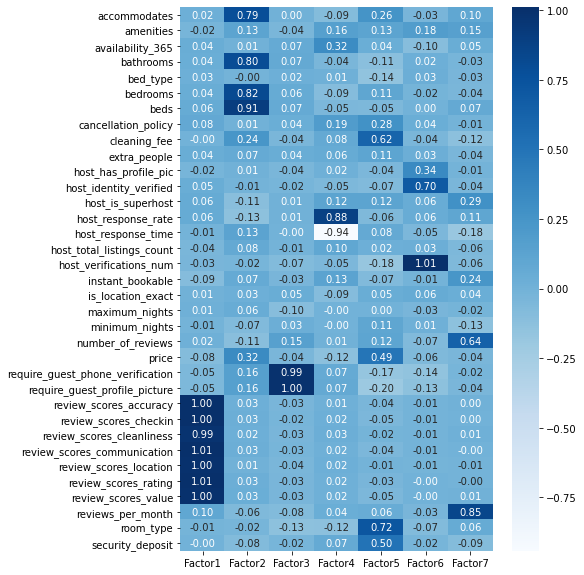

In [37]:
fa = FactorAnalyzer(n_factors=7, rotation = "promax")
fa.fit(data_scale)
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6','Factor7'],
                                 index=data_scale.columns)
plt.figure(figsize=(7,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')

<AxesSubplot:>

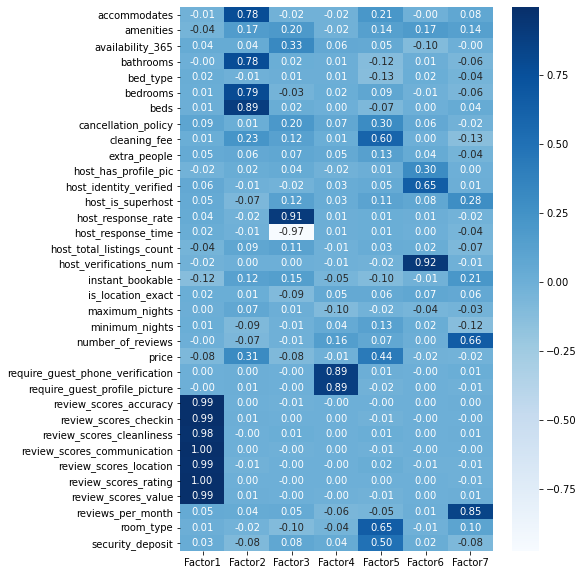

In [38]:
fa = FactorAnalyzer(n_factors=7, rotation = "oblimin")
fa.fit(data_scale)
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6','Factor7'],
                                 index=data_scale.columns)
plt.figure(figsize=(7,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')

<AxesSubplot:>

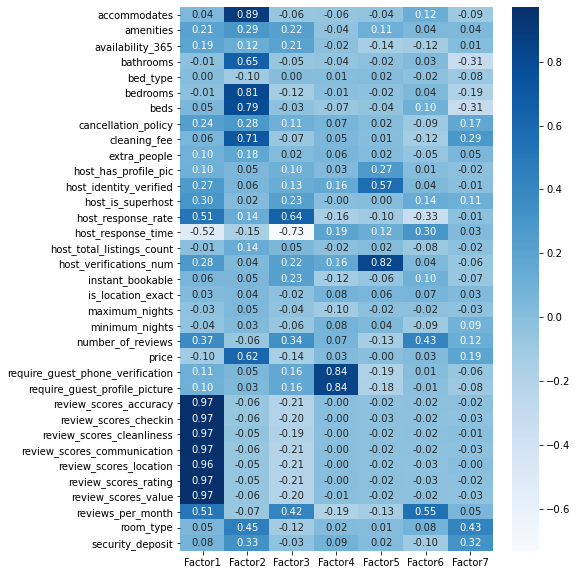

In [39]:
fa = FactorAnalyzer(n_factors=7, rotation = "oblimax")
fa.fit(data_scale)
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6','Factor7'],
                                 index=data_scale.columns)
plt.figure(figsize=(7,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')

<AxesSubplot:>

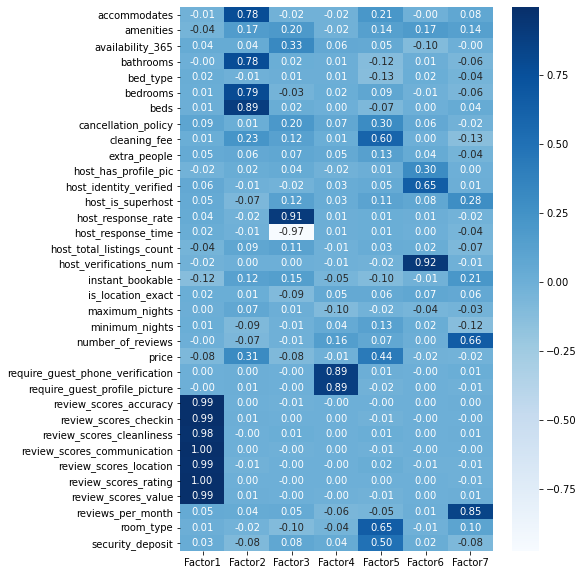

In [40]:
fa = FactorAnalyzer(n_factors=7, rotation = "quartimin")
fa.fit(data_scale)
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6','Factor7'],
                                 index=data_scale.columns)
plt.figure(figsize=(7,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')

<AxesSubplot:>

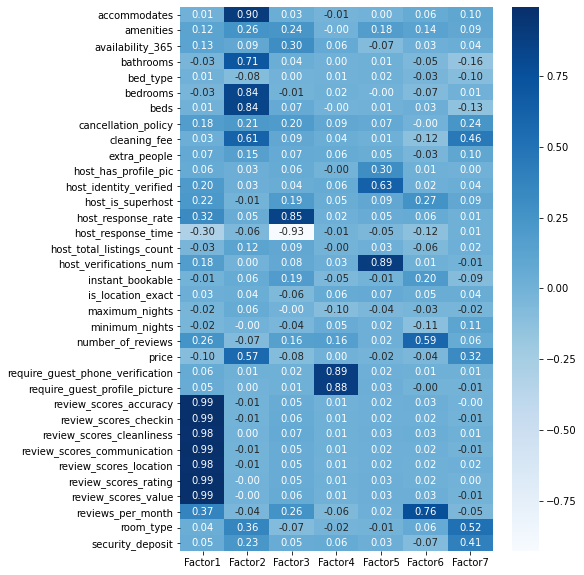

In [41]:
fa = FactorAnalyzer(n_factors=7, rotation = "equamax")
fa.fit(data_scale)
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6','Factor7'],
                                 index=data_scale.columns)
plt.figure(figsize=(7,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')